## Final Project Submission

Please fill out:
* Student name: Raymond Willey
* Student pace: self paced
* Scheduled project review date/time: January 2, 2019 7:00pm EST
* Instructor name: Eli Thomas
* Blog post URL: https://rwilleyii.blogspot.com/

# Module 1 Project
**Primary Stakeholder:** A company that buys houses in King County with the intent of remodeling / renovating and reselling at higher prices.

**Problem Statement:** Given King County home sales data in the last year, identify the most important factors that impact price, and make recommendations on how the firm can maximize its profits.

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn as sk
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime as dt
import calendar

## Importing the Data

The below column names and descriptions were provided with the data set.
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
* **sqft_lot15** - lotSize area in 2015(implies-- some renovations)

In [2]:
# Save dataset to dataframe for analysis
housing_data = pd.read_csv('kc_house_data.csv')
housing_data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
housing_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Key Observations
* **id:** Saved as integer, but should be treated as string.
* **dateDate:** If considering market trends, may want to convert from string to other date formats.
* **pricePrice:** Prediction target.
* **bedrooms:** Number of bedrooms. Possible outliers with at least one home having 33 bedrooms.
* **bathrooms:** Number of bathrooms. Possible outliers with at least one home having 8 bathrooms. 
* **sqft_living:** Square footage of the home. (Correction made to column name.)
* **sqft_lot:** Footage of the lot. Not likely to be needed as 2015 lot square will be more relevant.
* **waterfront** Has null values that will need to be dealt with.
* **view:** Has some null values, and appears to represent number of times viewed, not simply "has been viewed."
* **condition:** Unclear if higher number represents better or worse condition. Will require further investigation.
* **sqft_basement:** Saved as string; suggests there may be some placeholder values
* **yr_renovated:** Has many null values, but other columns imply renovations. May be able to still extract useful information before dropping column.
* **zipcode:** Should be converted to string
* **sqft_living15:** Max living room size of 870k square feet suggests this is not just living room size, but total living area in 2015. Will need to compare with `sqft_living` to be sure.

### Questions
**Question 1:** How much do market conditions affect price (i.e. do time of year or inflationary trends impact the price)?

**Question 2:** Does location impact the price? If so, should latitude/longitude or zip code be used?

**Question 3:** Number of bedrooms, bathrooms, and floors is likely to increase with square footage, but does the density of rooms make a difference in the price? Do people care about having more rooms or larger rooms? Do buyers pay a premium for building upwards or outwards?

## Data Scrubbing

In [5]:
housing_data.isna().sum() # Checking for null values.

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Dealing with Null Values
Items with null values: 
* `waterfront`
* `view`
* `yr_renovated`

**waterfront:** Series of floats with value of 1 or 0, with 1 indicating house has a view to the waterfront. Given ~2,400 null values with a mean of 0.09, best approach is to replace null values with the mode of 0.

In [6]:
# Convert waterfront column to bool. All null values will automatically be assigned false.
housing_data['waterfront'] = housing_data['waterfront'].astype('bool')

**view:** Appears to be times viewed, not simply if viewed. With only 63 null values, best to drop these rows.

In [7]:
# Drop null values from view column
housing_data = housing_data[pd.notnull(housing_data['view'])]

**yr_renovated:** `sqft_lot15` and `sqft_living15` imply renovations. If the initial and 2015 sizes differ, it can be concluded that the home as been renovated. Instead of focusing on just `yr_renovated`, these three columns can be used to create a boolean column called `renovated` to indicate if renovated or not.

*Note: A check will first be performed on the differences between living areas to validate assumption that the description is incorrect, and that the column does, in fact, represent total living area in 2015.*

In [8]:
housing_data['delta_living'] = housing_data['sqft_living'] - housing_data['sqft_living15']
housing_data['delta_living'].describe()

count    21534.000000
mean        93.527909
std        600.376318
min      -2310.000000
25%       -220.000000
50%          0.000000
75%        310.000000
max       8690.000000
Name: delta_living, dtype: float64

Wide variations in differences, included negative values, implies the data in this column is unreliable. It is unlikely the total living area would decrease substantially after a renovation, and it is equally unlikely that the 2015 living room area will exceed the total square footage of home prior to the renovation.

If the square footage of `sqft_living15` is larger than `sqft_living`, it can safely be assumed there was a renovation. Otherwise, it will be assumed the home has not been renovated.

In [9]:
housing_data['delta_lot'] = housing_data['sqft_lot'] - housing_data['sqft_lot15']
renovated_conditions = (housing_data['delta_lot'] != 0) | (housing_data['delta_living'] > 0) | (housing_data['yr_renovated'] > 0)

housing_data['renovated'] = np.where(renovated_conditions, True, False) 
housing_data.drop(columns=['yr_renovated', 'delta_lot', 'delta_living'], inplace=True)
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null bool
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
renovated        21534 non-null bool
dtypes: bool(2), float64(6), int64(11), object(2)
memory usage: 3.3+ MB


### Placeholder Values
Based on the min and max values of the columns of integer and float columns, no placeholder values appear to be present.  

**sqft_basement:** Incorrect data type implies placeholder values exist. If so, value may be derived by subtracting `sqft_above` from `sqft_living`. The following approach will be taken:

* Perform caluculation for all columns and save to new column.
* Replace placeholders with calculated value. 
* Check for differences between calulated and given values to validate assumption.

In [10]:
# Check for placeholder value in head; sorting likely to put placeholder at top or bottom of list
pd.value_counts(housing_data['sqft_basement'], ascending=True).head(2)

556.0     1
2850.0    1
Name: sqft_basement, dtype: int64

In [11]:
pd.value_counts(housing_data['sqft_basement'], ascending=True).tail(2)

?        452
0.0    12798
Name: sqft_basement, dtype: int64

Placeholder value identified as *'?'*. Continue with the approach outlined above.

In [12]:
# Replace placeholders with difference of sqft_living and sqft_above, then convert column to float
housing_data['sqft_bsmt_calc'] = housing_data['sqft_living'] - housing_data['sqft_above']
housing_data['sqft_basement'].replace(to_replace = '?', value = housing_data['sqft_bsmt_calc'], inplace=True)
housing_data['sqft_basement'] = housing_data['sqft_basement'].astype('float64')

In [13]:
# Check for inconsistencies
housing_data['bsmt_discrepancies'] = housing_data['sqft_bsmt_calc'] - housing_data['sqft_basement']
pd.value_counts(housing_data['bsmt_discrepancies'])

0.0    21534
Name: bsmt_discrepancies, dtype: int64

There are no inconsistencies with the assumption that the difference between the total living area and the living area above the basement is equal to the square footage of the basement. The only thing left is to drop the columns used for this check (`sqft_bsmt_calc` and `bsmt_discrepancies`).

In [14]:
housing_data = housing_data.drop(columns = ['sqft_bsmt_calc', 'bsmt_discrepancies'])
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null bool
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null float64
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
renovated        21534 non-null bool
dtypes: bool(2), float64(7), int64(11), object(1)
memory usage: 4.0+ MB


In [15]:
housing_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.153400e+04,2.153400e+04,21534.000000,21534.000000,21534.000000,2.153400e+04,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000
mean,4.582351e+09,5.400577e+05,3.373038,2.115712,2079.827854,1.509060e+04,1.494126,0.233863,3.409724,7.657425,1788.557537,291.270317,1971.002275,98077.939352,47.560180,-122.213948,1986.299944,12751.079502
std,2.876779e+09,3.660596e+05,0.926410,0.768602,917.446520,4.138021e+04,0.539806,0.765686,0.650654,1.172643,827.745641,442.199825,29.376044,53.506639,0.138528,0.140735,685.121001,27255.483308
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123212e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,98033.000000,47.471200,-122.328000,1490.000000,5100.000000
50%,3.904945e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.617000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,7.312175e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068775e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,98118.000000,47.678100,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Dealing with Incorrect Data Types
After checking for placeholder values, the following columns will be converted to strings.

**id:** Convert to string.

**zipcode:** Convert to strings and check for placeholder values. One-hot-encode at end of scrubbing process.

In [16]:
pd.value_counts(housing_data['zipcode'], ascending=True).head(2)

98039    50
98148    57
Name: zipcode, dtype: int64

In [17]:
pd.value_counts(housing_data['zipcode'], ascending=True).tail(2) # No placeholders appear to be present

98038    586
98103    601
Name: zipcode, dtype: int64

In [18]:
pd.value_counts(housing_data['id'], ascending=True).head(2) 

1777500160    1
9492500170    1
Name: id, dtype: int64

In [19]:
pd.value_counts(housing_data['id'], ascending=True).tail(2)

5430300171    2
795000620     3
Name: id, dtype: int64

No placeholders appear to be present; however, some homes appear to have been sold / resold throughout the year. Given enough time, it would be a good idea to perform an additional analysis that examines changes made (if any) and the impact on the price. 

*This will not be in scope for the initial approach here.*

In [20]:
# Convert data types to strings
housing_data['id'] = housing_data['id'].astype('str')
housing_data['zipcode'] = housing_data['zipcode'].astype('str')

**Date Adjustments:** Create an `ordinal_date` column to see if there are any price trends over time, and create a `month` column to determine if certain times of the year yield higher prices.

In [21]:
# Convert date to date/time format
housing_data['date'] = pd.to_datetime(housing_data['date'])

# Assign month of sales to column month
housing_data['month'] = housing_data['date'].dt.month
housing_data['month'] = housing_data['month'].apply(lambda x: calendar.month_abbr[x])

# Convert date to ordinal date
housing_data['ordinal_date'] = housing_data['date'].map(dt.datetime.toordinal)

In [22]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 23 columns):
id               21534 non-null object
date             21534 non-null datetime64[ns]
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null bool
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null float64
yr_built         21534 non-null int64
zipcode          21534 non-null object
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
renovated        21534 non-null bool
month            21534 non-null object
ordinal_date     21534 non-null

In [23]:
housing_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,ordinal_date
count,2.153400e+04,21534.000000,21534.000000,21534.000000,2.153400e+04,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000
mean,5.400577e+05,3.373038,2.115712,2079.827854,1.509060e+04,1.494126,0.233863,3.409724,7.657425,1788.557537,291.270317,1971.002275,47.560180,-122.213948,1986.299944,12751.079502,735535.078713
std,3.660596e+05,0.926410,0.768602,917.446520,4.138021e+04,0.539806,0.765686,0.650654,1.172643,827.745641,442.199825,29.376044,0.138528,0.140735,685.121001,27255.483308,113.065260
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,47.155900,-122.519000,399.000000,651.000000,735355.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,47.471200,-122.328000,1490.000000,5100.000000,735436.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.617000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,47.571900,-122.230000,1840.000000,7620.000000,735522.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068775e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,47.678100,-122.125000,2360.000000,10083.000000,735646.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,735745.000000


### Checking for Multicollinearity

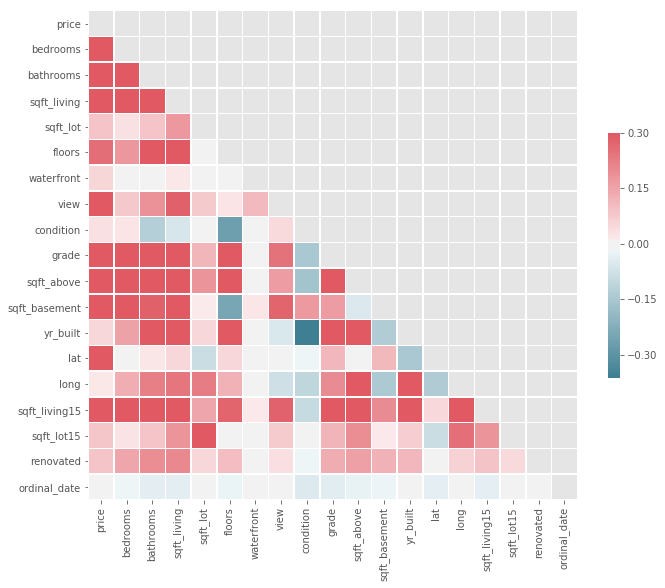

In [24]:
plt.style.use('ggplot')

def coll_check(data):
    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = (11,9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.savefig('cov_matrix_' + str(len(data.columns)) + '_inputs.png', dpi=100)

coll_check(housing_data)

### Columns to be Dropped

**Bedrooms, Bathrooms, & Floors:** These items have high correlation with total square footage. Columns will be created which reflect the ratio of each to total square footage. This is likely to provide greater insight.

**Living Room 2015:** Data has shown to be unreliable, and what insight can be provided has already been captured in the `renovated` column.

**Basement Size:** Has high correlation with price and total square footage, but to increase basement size would likely require complete home rebuild. 

**Living Area Above Basement:** It is only natural that square footage of shared spaces increase with the square footage of the home. Any relevant information here will be captured in the total square footage. To keep this column instead of total square footage would omit information about basement square footage, which may still be relevant, even if not as a direct predictor.

**Lot Size:** Current lot size (`sqft_lot15`) is more relevant than past lot size.

**Year Built:** High inverse correlation with the `condition`, which means newer homes have lower condition rating. This suggests that lower `condition` ratings are better. However, `condition` also has slightly positive correlation with price, which implies the opposite. Renovations could have something to do with this discrepancy. This might be worth exploring in a later analysis, but for now, this column will be dropped in favor of the `condition` rating.

**Longitude:** Has high correlation with lot and house size, as well as year built, but low correlation with price. This suggests that older homes were built in the west, and newer homes were built in the east. This suggests that newer homes and lots are bigger to compensate for lack fo preferable location. However, these other factors have more directly observable correlations with price, and are likely to provide a clearer picture of the data. It may be possible to later normalize based on this information to better understand the impact of east/west proximity on price.

**View**: It would be foolish to assume that by simply showing a home more, the price will increase. In all likelihood, homes with more preferable characteristics will have more requests for viewing. Should be treated as a dependent variable in other analyses, but is not useful for the objectives of this analysis.

**Grade:** Though a strong predictor of price, its usefulness is limited. Without having clarity on the methodology that drives the grade, it will be difficult to extract any actionable information.

In [25]:
# Create columns that show the ratio of each to the total square footage of the home
housing_data['bed_sqft_ratio'] = housing_data['bedrooms'] / housing_data['sqft_living']
housing_data['bath_sqft_ratio'] = housing_data['bathrooms'] / housing_data['sqft_living']
housing_data['floors_sqft_ratio'] = housing_data['floors'] / housing_data['sqft_living']

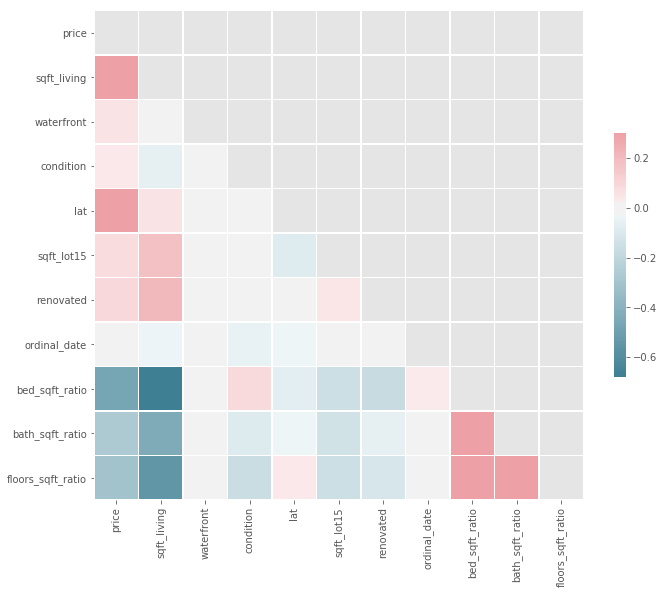

In [26]:
to_drop = ['bedrooms', 'bathrooms', 'sqft_above', 'sqft_basement', 'sqft_living15', 'floors', 'sqft_lot', 'yr_built', 'long', 'grade', 'view']
coll_check(housing_data.drop(columns=to_drop))

The square footage ratio columns have a strong, negative correlation with the total square footage of the living area. This makes sense as, with smaller homes, rooms must fit into less space. Larger homes tend to have additional types of rooms, such as a family room or formal dining room. 

Despite this correlation, the relationship of rooms and floors to square footage is something worth exploring as these features will be easist for the firm to identify and manipulate when seeking out homes to renovate. Even if these relationships cannot be completely separated, they may still be able to provide valuable insights.

In [27]:
# Drop necessary columns and save to new dataframe. ID and Date columns added to the to_drop columns
# ID is not a predictor variable; Date has been converted to ordinal and month formats
to_drop = to_drop + ['id', 'date'] 
housing_data_cleaned = housing_data.drop(columns=to_drop)
housing_data_cleaned.head()

,price,sqft_living,waterfront,condition,zipcode,lat,sqft_lot15,renovated,month,ordinal_date,bed_sqft_ratio,bath_sqft_ratio,floors_sqft_ratio
0,221900.0,1180,True,3,98178,47.5112,5650,False,Oct,735519,0.002542,0.000847,0.000847
1,538000.0,2570,False,3,98125,47.7210,7639,True,Dec,735576,0.001167,0.000875,0.000778
2,180000.0,770,False,3,98028,47.7379,8062,True,Feb,735654,0.002597,0.001299,0.001299
3,604000.0,1960,False,5,98136,47.5208,5000,True,Dec,735576,0.002041,0.001531,0.000510
4,510000.0,1680,False,3,98074,47.6168,7503,True,Feb,735647,0.001786,0.001190,0.000595


# Exploring Data

In [28]:
# Convert waterfront and renovated to categorical variables, and get dummies from zipcode and month
housing_data_cleaned['waterfront'] = housing_data_cleaned.waterfront.astype('int')
housing_data_cleaned['renovated'] = housing_data_cleaned.renovated.astype('int')

housing_data_cleaned = pd.get_dummies(housing_data_cleaned)
housing_data_cleaned.head()

,price,sqft_living,waterfront,condition,lat,sqft_lot15,renovated,ordinal_date,bed_sqft_ratio,bath_sqft_ratio,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,221900.0,1180,1,3,47.5112,5650,0,735519,0.002542,0.000847,...,0,0,0,0,0,0,0,0,1,0
1,538000.0,2570,0,3,47.7210,7639,1,735576,0.001167,0.000875,...,1,0,0,0,0,0,0,0,0,0
2,180000.0,770,0,3,47.7379,8062,1,735654,0.002597,0.001299,...,0,1,0,0,0,0,0,0,0,0
3,604000.0,1960,0,5,47.5208,5000,1,735576,0.002041,0.001531,...,1,0,0,0,0,0,0,0,0,0
4,510000.0,1680,0,3,47.6168,7503,1,735647,0.001786,0.001190,...,0,1,0,0,0,0,0,0,0,0


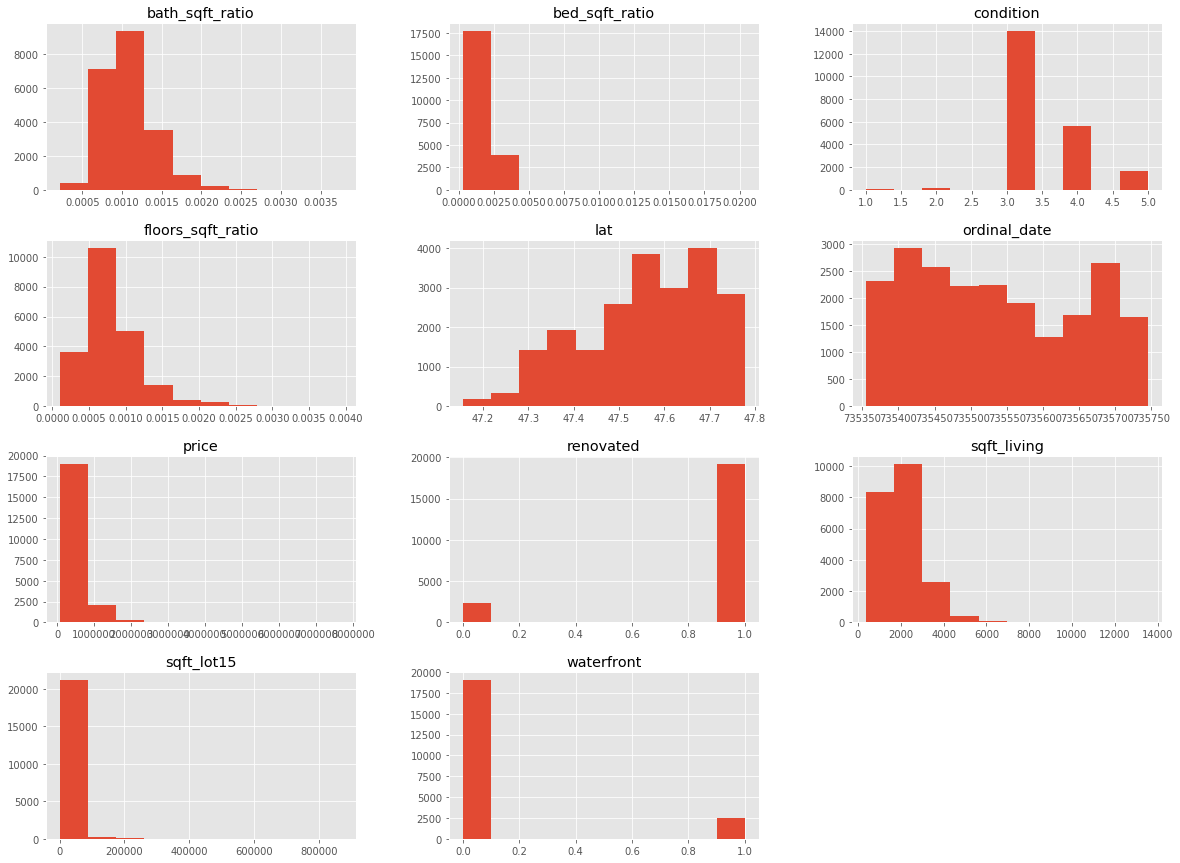

In [29]:
# Create histograms of numerical columns to explore distribution of data
housing_data_cleaned.iloc[:, 0:11].hist(figsize = (20, 15))
plt.savefig('hist_orig_housing_data.png', dpi=100)

Ignoring `renovated` and `waterfront` because those are categorical, most of the data is strongly skewed, suggesting a log normalization may be appropriate. 

`oridnal_date` exhibits a slight left skewness, so it is unlikely that this will serve as a valid predictor. This coincides with the correlation matrix, which exhibited little to no correlation with price. Nevertheless, a log normalization will be applied to at least check.

## Z-Score Standardization and Log Normalization
In addtion to log normalization, Z-Score standardization will be applied to all numberical variables.

In [30]:
numerical_columns = ['condition', 'lat', 'ordinal_date', 'sqft_living', 'sqft_lot15', 'bed_sqft_ratio', 'bath_sqft_ratio', 'floors_sqft_ratio', 'price']

for column in numerical_columns:
    housing_data_cleaned[column] = np.log(housing_data_cleaned[column])
    housing_data_cleaned[column] = (housing_data_cleaned[column] - housing_data_cleaned[column].mean())/housing_data_cleaned[column].std()
    
housing_data_cleaned.loc[:, numerical_columns].head(5)

,condition,lat,ordinal_date,sqft_living,sqft_lot15,bed_sqft_ratio,bath_sqft_ratio,floors_sqft_ratio,price
0,-0.613015,-0.352045,-0.142134,-1.125162,-0.395196,1.231949,-0.705267,0.321287,-1.402334
1,-0.613015,1.159591,0.361998,0.709983,-0.024014,-1.176810,-0.590720,0.123926,0.280395
2,-0.613015,1.281068,1.051800,-2.131578,0.042313,1.298216,0.797487,1.309616,-1.799954
3,2.204300,-0.282730,0.361998,0.071161,-0.545604,0.551932,1.375887,-0.853536,0.500259
4,-0.613015,0.409649,0.989897,-0.292266,-0.046121,0.138714,0.491179,-0.496640,0.178843


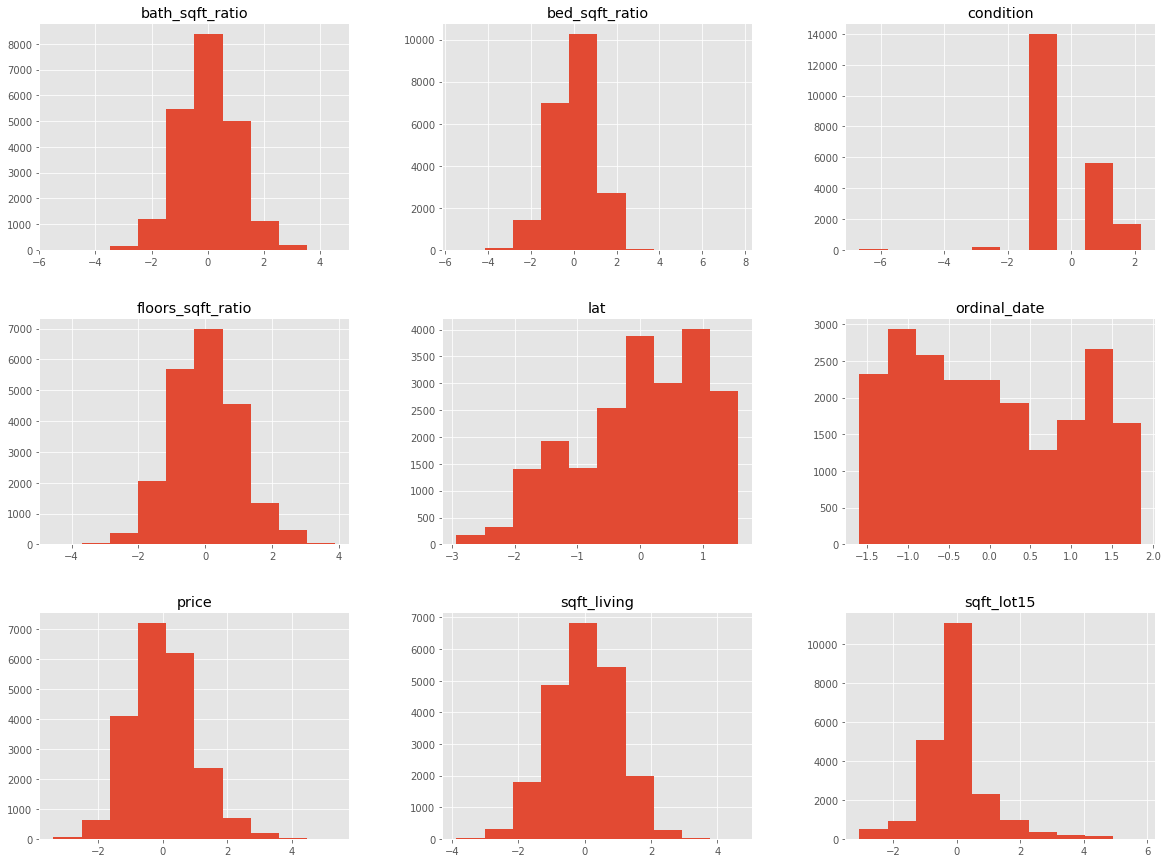

In [31]:
housing_data_cleaned.loc[:, numerical_columns].hist(figsize = (20, 15))
plt.savefig('hist_lognorm_housing_data.png', dpi=100)

While most data was left skewed before log normalization, the skewness is now primarily on the left, though not to the same extreme. 

The dependent variable, `price`, exhibits significant improvement, so we should be able to glean some useful information.

`oridinal_date` exhibits strong right skewness, but it is much closer to a normal distribution. This skewness suggests there are certainly some market factors at play as the market appears to be getting more and more active. Still, a deeper analysis of supply and demand will likely be required to gain any real insight. The necessary data is not available in this dataset. On it's own, the information is interesting, but not likely to be granular enough to provide any relevant insights.

In addition to the above histograms, distribution plots will be generated that will make it easier to examine the distribution.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


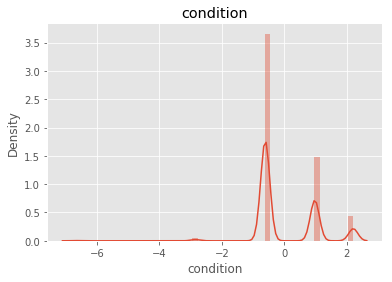

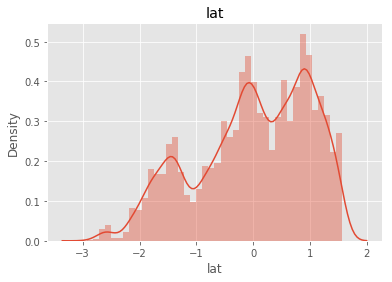

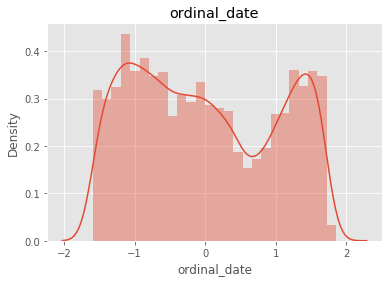

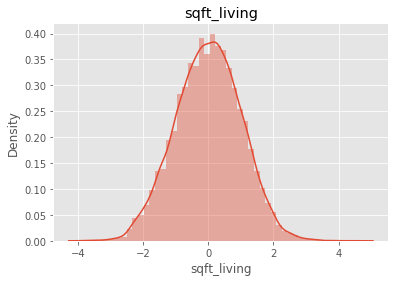

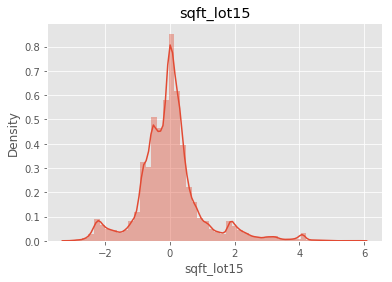

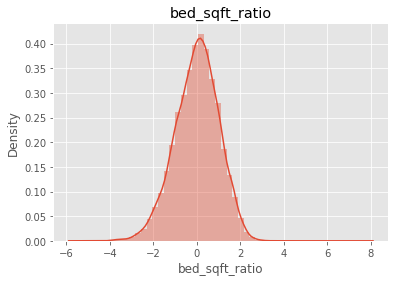

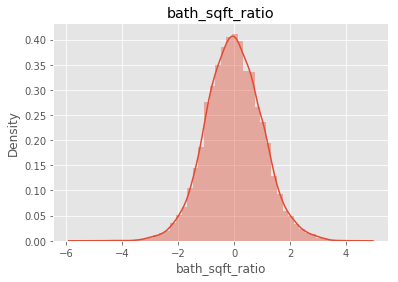

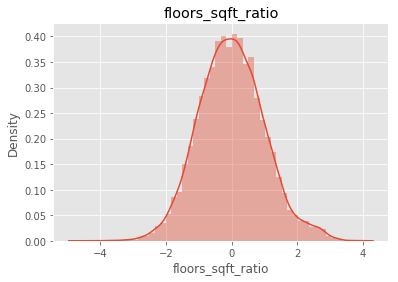

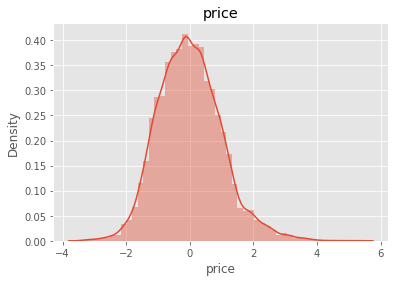

In [32]:
for column in numerical_columns:
    sns.distplot(housing_data_cleaned[column])
    plt.title(column)
    plt.ylabel('Density')
    plt.savefig('distplot_' + column + '.png', dpi=100)
    plt.show()

All variables related to square footage exhibit a strongly normal distribution, as does the price, suggesting these are likely to have the strongest linear relationships.

# Building the Model

### Numerical Predictors
Before building a consolidated model: coefficients, p-values, and r-squared for each of the numerical data predictors will be generated to understand the relationships with price independently. Scatterplots with prediction lines will also be created to visualize the relationships to price.

,Variable,R Squared,Intercept,Slope,P Value
0,condition,0.001825,-2.157129e-14,0.042718,3.582996e-10
1,lat,0.201983,2.053449e-12,0.449426,0.000000e+00
2,ordinal_date,0.000022,-7.736737e-12,-0.004699,4.904649e-01
3,sqft_living,0.455053,-1.417547e-13,0.674576,0.000000e+00
4,sqft_lot15,0.015288,1.826664e-15,0.123645,4.057612e-74
5,bed_sqft_ratio,0.342594,1.075875e-14,-0.585315,0.000000e+00
6,bath_sqft_ratio,0.083350,-1.025152e-13,-0.288703,0.000000e+00
7,floors_sqft_ratio,0.159239,2.168057e-14,-0.399048,0.000000e+00


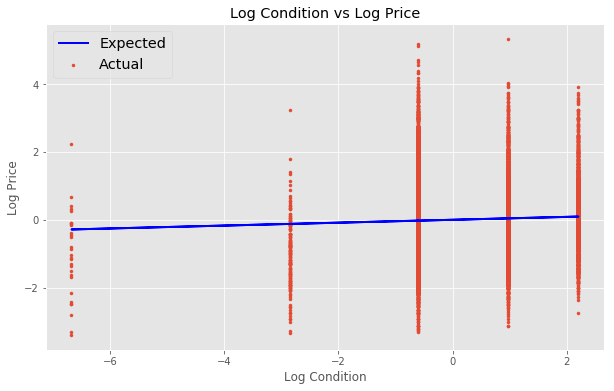

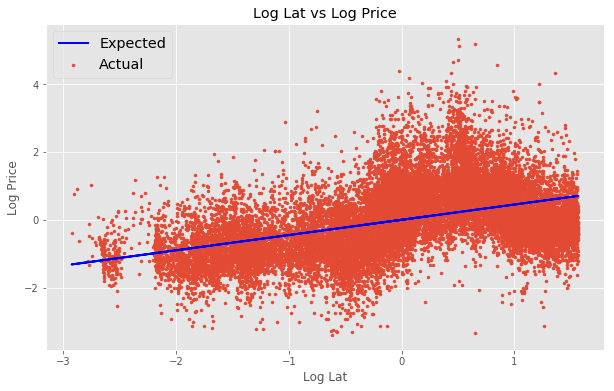

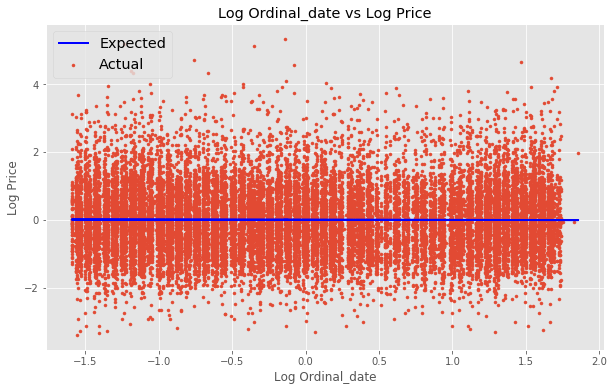

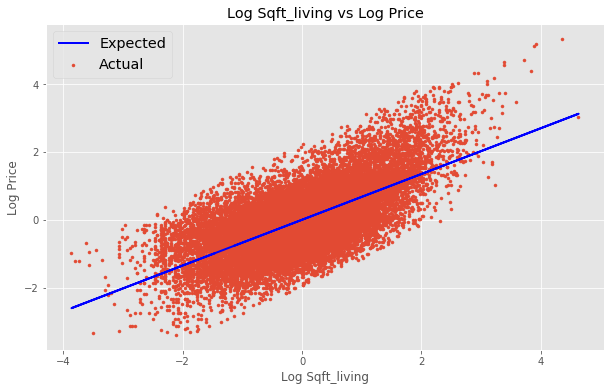

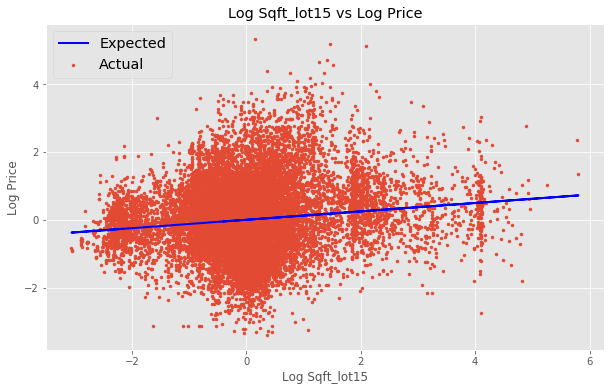

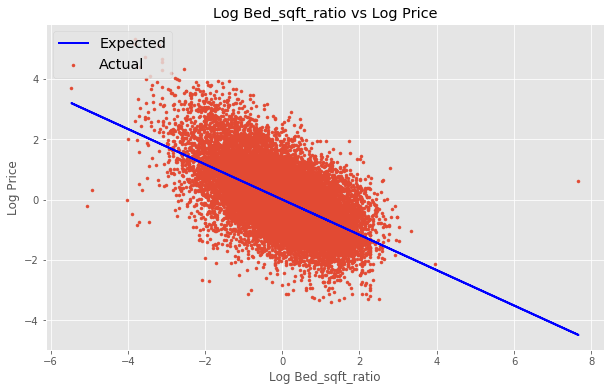

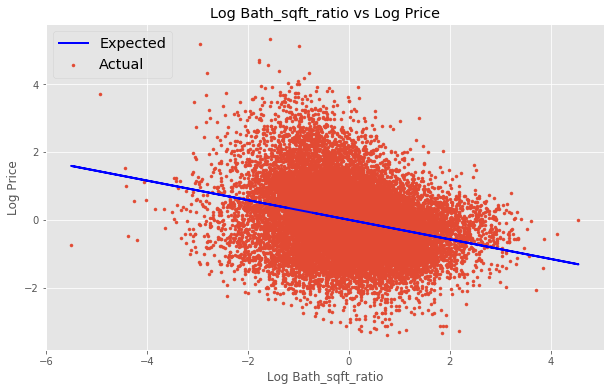

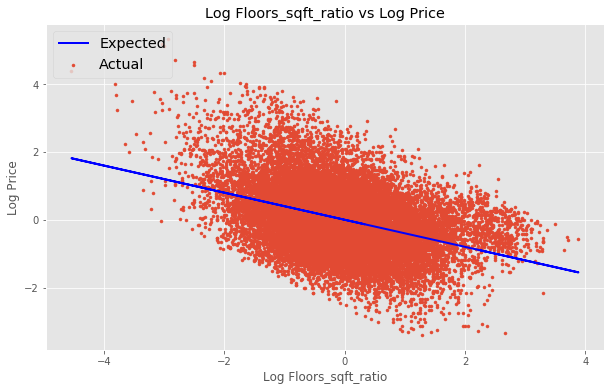

In [33]:
predictors = housing_data_cleaned.loc[:, numerical_columns[:-1]].columns

results = [['Variable', 'R Squared', 'Intercept', 'Slope', 'P Value']]

for predictor in predictors:
    f = 'price~' + predictor
    model = smf.ols(formula=f, data=housing_data_cleaned).fit()
    results.append([predictor, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
    y_pred = model.predict()
    plt.figure(figsize=(10, 6))
    plt.title('Log ' + predictor.capitalize() + ' vs Log Price')
    plt.xlabel('Log ' + predictor.capitalize())
    plt.ylabel('Log Price')
    plt.scatter(housing_data_cleaned[predictor], housing_data_cleaned['price'], marker='.', label='Actual')
    plt.plot(housing_data_cleaned[predictor], y_pred, color='b', lw=2, label='Expected')
    plt.legend(loc=2, fontsize='x-large')
    plt.savefig('scatter_log_' + f + '.png', dpi=100)

result_df = pd.DataFrame(results[1:],columns=results[0])
result_df

Based on the graphs and r-squared values, `conditition` and `ordinal_date` do not appear to be strong predictors of price. No clear market trends appear to be affecting the price.

While `lat`itude does have a respectable r-squared value of 0.202, the graph clearly shows that the relationship between price and north/south proximity is not linear. If zip codes have strong predictive power, `lat` will be dropped.

Total square footage is clearly the strongest predictor of price, as is the bedrooms to square footage ratio. However, expectations of the latter should be tempered as it is already known that there is a strong, negative correlation with square footage.

Lot size does have an impact on price, though it is not among the strongest variables that predict price.

### Categorical Predictors
Models to be created for categorical variables.

In [34]:
renovated = ['renovated']
waterfront = ['waterfront']
zips = [col for col in housing_data_cleaned.columns if 'zipcode' in col]
months = [col for col in housing_data_cleaned.columns if 'month' in col]

columns = [renovated, waterfront, zips[:-1], months[:-1]]

for column in columns:
    f = 'price~'+ "+".join(column)
    model = smf.ols(formula=f, data=housing_data_cleaned).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     233.1
Date:                Fri, 04 Jan 2019   Prob (F-statistic):           2.32e-52
Time:                        17:47:28   Log-Likelihood:                -30439.
No. Observations:               21534   AIC:                         6.088e+04
Df Residuals:                   21532   BIC:                         6.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2961      0.021    -14.414      0.0

**ZipCode** is clearly the most relevant variable that impacts price, even over square footage, so **latitude** will be dropped.

While `renovated` is not a strong predictor, it's r-squared value just above 1% makes it worth keeping for now.

Whether or not the home has a **waterfront** view seems to be irrelevant, as does the time of year based on **month**. Market trends will require deeper analysis with additional data.

In [35]:
housing_data_cleaned = housing_data_cleaned.drop(columns = ['condition', 'ordinal_date', 'waterfront', 'lat'] + months + zips[-1:])
housing_data_cleaned.head()

,price,sqft_living,sqft_lot15,renovated,bed_sqft_ratio,bath_sqft_ratio,floors_sqft_ratio,zipcode_98001,zipcode_98002,zipcode_98003,...,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198
0,-1.402334,-1.125162,-0.395196,0,1.231949,-0.705267,0.321287,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.280395,0.709983,-0.024014,1,-1.176810,-0.590720,0.123926,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.799954,-2.131578,0.042313,1,1.298216,0.797487,1.309616,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.500259,0.071161,-0.545604,1,0.551932,1.375887,-0.853536,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.178843,-0.292266,-0.046121,1,0.138714,0.491179,-0.496640,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Run model with all remaining predictors to estimate predictive power.
columns = housing_data_cleaned.columns[1:]

f = 'price~'
for column in columns:
    f = f + '+' + column
model = smf.ols(formula=f, data=housing_data_cleaned).fit()
print(model.summary())
dict(model.params[0:7])

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1404.
Date:                Fri, 04 Jan 2019   Prob (F-statistic):               0.00
Time:                        17:47:28   Log-Likelihood:                -11432.
No. Observations:               21534   AIC:                         2.302e+04
Df Residuals:                   21458   BIC:                         2.362e+04
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.9284      0.02

{'Intercept': 0.9284281520617423,
 'sqft_living': 0.5592518177726031,
 'sqft_lot15': 0.13730755832951375,
 'renovated': -0.09192646356071907,
 'bed_sqft_ratio': -0.09330041322328583,
 'bath_sqft_ratio': 0.03788438465148497,
 'floors_sqft_ratio': 0.054168827378111906}

When all individual, statistically significant predictors are considered, the picture changes significantly. While the number of bedrooms relative to square footage still captures the negative correlation with price, the number of bathrooms and floors relative to square footage exhibit a positive correlation with price. This is likely driven most by price, so despite their statistical significance, they will be dropped.

Interestingly, renovated homes exhibit a negative correlation with price. It might be best to target homes that have already been renovated and focus on expanding the square footage.

In [37]:
# housing_data_cleaned = housing_data_cleaned.drop(columns = ['bath_sqft_ratio', 'floors_sqft_ratio'])
# housing_data_cleaned.head()

In [38]:
# # Run model with all remaining predictors to estimate predictive power.
# columns = housing_data_cleaned.columns[1:]

# f = 'price~'
# for column in columns:
#     f = f + '+' + column
# model = smf.ols(formula=f, data=housing_data_cleaned).fit()
# print(model.summary())
# dict(model.params[0:5])

The model generated by dropping the ratios of floors and bathrooms to square footage negatively impacted the model. The adjusted r-squared value dropped from 0.830 to .0827. As such, these columns will be kept. 

*The code in the above two cells have been commented out to allow for validation of the findings.*

The current model yields an adjusted r-squred of 0.830, indicating that approximately 83% of the variability in price can be explained by the model. 

The ratio coefficients suggest that, while adding floors and/or bathrooms to get more square footage is beneficial, adding bedrooms can be detrimental unless the additional square footage is substantial. Specifically, each additional bedroom should occupy no more than 9.33% of the additional square footage.

# Testing the Model
The data will now be split into test and train sets to test the true predictive power of the model using the mean squared error (mse).

In [39]:
X = housing_data_cleaned.drop(columns = ['price'])
y = housing_data_cleaned['price']

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
    
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.8, 
                                                    random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('Train Mean Squared Error: %0.2f' % (train_mse))
print('Test Mean Squared Error: %0.2f' % (test_mse))

Train Mean Squared Error: 0.17
Test Mean Squared Error: 0.17


The MSE and RMSE for the test and train sets are not significantly different, suggesting the model is a good fit.

### K-Fold Cross Validation
Iterate over 10 splits of the data and calculate the average MSE.

In [41]:
from sklearn.model_selection import cross_val_score

cv_10_results = cross_val_score(linreg, X, y, cv=10)

print('Accuracy: %0.2f (+/- %0.2f)' % (cv_10_results.mean(), cv_10_results.std() * 2))

Accuracy: 0.83 (+/- 0.01)


The adjusted r-square and average MSE indicate that ~83% of the variance in price can be explained by the model.

Given the strength of **zip codes** as a predictor, a bar chart will be created below to highlight the top 5 zip codes by highest average selling price.

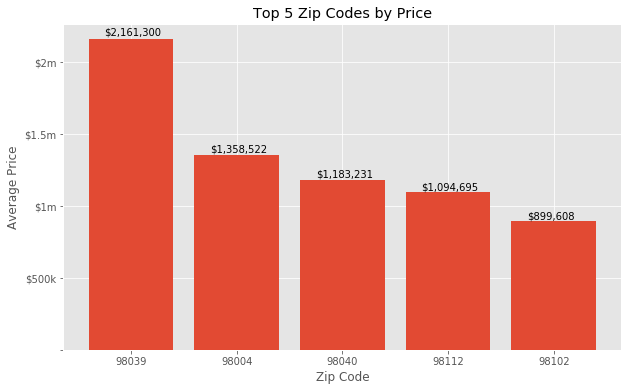

In [42]:
import matplotlib.ticker as mtick

# Create a list of mean average selling prices in each zip code
zipcodes = housing_data['zipcode'].unique()
mean_prices = []

for zipcode in zipcodes:
    mean_price = housing_data.loc[housing_data['zipcode'] == zipcode]['price'].mean()
    mean_prices.append(mean_price)

# Create dataframe containing unique zip codes and average selling prices
zip_df = pd.DataFrame()
zip_df['zipcodes'] = zipcodes
zip_df['avg_price'] = mean_prices

# Get top 5 highest average selling prices and create bar chart
top5zips = zip_df.nlargest(5, 'avg_price')
x = top5zips['zipcodes']
y = top5zips['avg_price']

plt.figure(figsize=(10, 6))
plt.bar(x, y)
xpos = -.25
for i,j in zip(x,y):
    plt.annotate('${:,.0f}'.format(j),xy=(i,j), xytext=(xpos, j*1.015))
    xpos += 1
plt.xlabel('Zip Code')
plt.ylabel('Average Price')
plt.yticks(np.arange(0, 2500000, 500000), ('', '$500k', '$1m', '$1.5m', '$2m'))
plt.title('Top 5 Zip Codes by Price')
plt.savefig('Top 5 Zipcodes by Price.png')

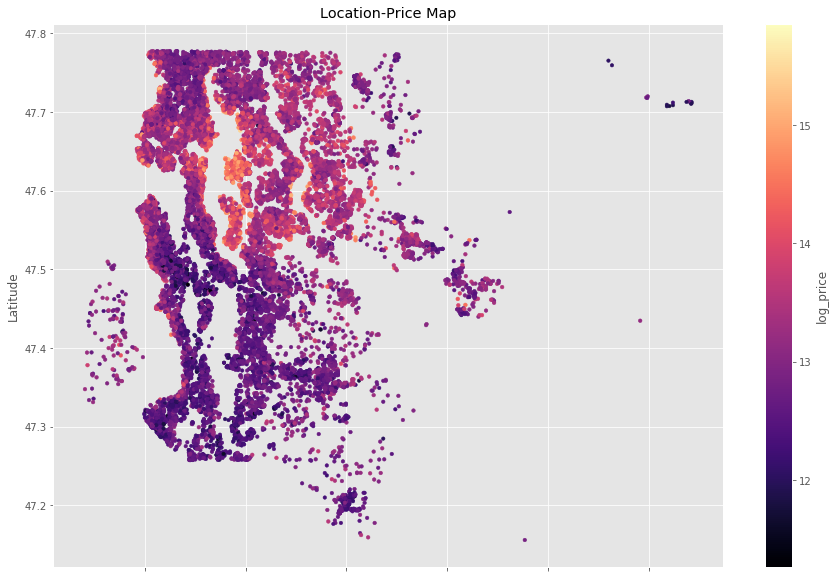

In [43]:
# Create scatter plot based on lat/long coordinates, with colors based on the log_selling price
# This can be used to get an idea of what areas have the best selling price

housing_data['log_price'] = np.log(housing_data['price'])

ax = housing_data.plot.scatter('long', 'lat', 
                  c = 'log_price',
                  s = housing_data['log_price'],
                 colormap = 'magma', 
                 figsize=(15, 10), title='Location-Price Map')
ax.set(xlabel='Longitude', ylabel='Latitude')
plt.savefig('Location-Price Map.png')

The most expensive areas appear to be clustered in the middle of the north-west quadrant of the county. Data will be exported to csv to create a more detailed and insightful visual using Tableau.

In [44]:
# Create new dataframe and save to csv
coord_price_df = housing_data.loc[:, ['log_price', 'lat', 'long']]
coord_price_df.head()

,log_price,lat,long
0,12.309982,47.5112,-122.257
1,13.195614,47.7210,-122.319
2,12.100712,47.7379,-122.233
3,13.311329,47.5208,-122.393
4,13.142166,47.6168,-122.045


In [45]:
coord_price_df.to_csv('coord_price.csv')

## Conclusion
**Question 1: How much do market conditions affect price (i.e. do time of year or inflationary trends impact the price)?**

Time of year based on month has no clear affect on sale price, nor do any trends appear to be driving prices up or down. However, volume of sales do appear to be increasing with time. The impacts on the supply and demand ratio should be examined with other data sources to better understand market impacts.

**Question 2: Does location impact the price? If so, should latitude/longitude or zip code be used?**

Location is the most statistically significant predictor of price, depending on the specific location. North/South proximity makes a bigger difference than East/West. However, relationship appears to be parabolic as opposed to linear. As such, zip codes serve as a stronger predictor overall. The top 5 most expensive zip codes are clustered in the same area, so it would be ideal to purchase homes in this area whenever possible. Based on what information is available from this analysis, focusing efforts on the north-west quadrant will be most beneficial. It would likely be worthwhile to dive deeper into the longitudinal impacts on price, normalizing for renovations, condition, and size.

**Question 3: Number of bedrooms, bathrooms, and floors is likely to increase with square footage, but does the density of rooms make a difference in the price? Do people care about having more rooms or larger rooms? Do buyers pay a premium for building upwards or outwards?**

While it is clear that buyers prefer larger homes and larger lots, how this space is used is also important. Any changes to the home should not attempt to pack more rooms into the same space. This suggests buyers are willing to pay more of a premium for larger rooms, as opposed to more rooms. In addition, though buyers are somewhat split in terms of preference building upward or outward, building upward has a slight edge. Whatever choice is made will likely have little impact on price as both factors offset each other. However, an easy win would be to build expansions on homes with half stories/floors. By expanding the half floor, more square footage can be added without taking away from lot size. Adding a large shared space (such as a gaming room) is likely to create the best return on investment. The ratio of floors to lot size could be considered, though significant gains should not be expected through such an analysis.

**Next Steps:**

Take a deeper dive into location, particularly with regard to longitude. It is clear and reasonable that latitude follows a parabolic distribution, with a peak price being directly related to proximity to Seattle. From a longitudinal perspective, because of eastward expansion over time, more research will be required to establish as clear of a relationship. Normalization for size and condition will be required.

Look at homes sold and resold in the past year. Examining changes to the home / property (or lack thereof) and the impact to sale price can provide more clarity to the most relevant factors that impact price.

Conduct additional research on the methodology that King County utilizes to determine a grade. This is a highly relevant factor in terms of sales price. It could prove to be beneficial in truly understanding how much weight consumers give to this factor. Is it merely correlated, or does causation exist? 

## Overall Approach Using OSEMN Framework
The data for this project was obtained from a pre-built csv file representing King County house sales in 2014-2015. It was saved in a dataframe called *housing_data* to begin the analysis. While details of the approach can be found in each section, null values were identified for the following series: basement size, year renovated, waterfront view, and number of times viewed. Data points were derived where possible, and replaced with the mode for the remainder. Rows were dropped only for the views series.

Before running any models, the data was explored using checks for multi-collinearity with a heatmap. Granular examination of precise correlation coefficients between independent variables was not deemed necessary for this particular dataset. Additional columns were derived to identify other factors not explicitly provided, which might help to better understand the predictors of price. Once this was completed, the distribution of variables was explored using histograms, and then scaled and log-transformed where appropriate. Distribution plots highlighted which variables most closely follow a log-normal distribution. Categorical variables with more than 2 categories were converted to dummies.

Models with scatterplots and prediction lines helped give a sense of which predictors had the strongest correlation with the price for numerical data. This also helped to eliminate variables that violate the conditions for running linear regression. Categorical variables relied exclusively on model outputs, though a scatterplot of home sales based on lat/long coordinates (combined with colors for sale price) gave clarity as to whether zip codes or lat/long coordinates were better for predictive purposes. The final set of predictors was then tested using K Fold Cross Validation with 10 cross-sections of data, yielding an average MSE of 0.17 +/- 0.01, indicating that approximately 83% of the variablity in price can be explained by the model.